# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load(as_pandas=False)
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(hub_results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(hub_results.params))]))

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.79189854 0.11100521 0.30293016 0.12864961]
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 17 Dec 2019                                         
Time:                        23:42:49                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.08950419 0.11945975 0.32235497 0.11796313]


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print('Parameters: ', andrew_results.params)

Parameters:  [-40.8817957    0.79276138   1.04857556  -0.13360865]


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1-5)**2))
X = sm.add_constant(X)
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 4.82458099  0.55057398 -0.01504094]
[0.44879492 0.06928788 0.00613091]
[ 4.4485574   4.7321673   5.01076564  5.28435242  5.55292764  5.8164913
  6.07504341  6.32858395  6.57711293  6.82063036  7.05913622  7.29263052
  7.52111326  7.74458445  7.96304407  8.17649214  8.38492864  8.58835358
  8.78676697  8.98016879  9.16855906  9.35193776  9.53030491  9.70366049
  9.87200452 10.03533698 10.19365789 10.34696723 10.49526502 10.63855125
 10.77682591 10.91008902 11.03834057 11.16158055 11.27980898 11.39302585
 11.50123115 11.6044249  11.70260709 11.79577772 11.88393678 11.96708429
 12.04522024 12.11834463 12.18645746 12.24955873 12.30764843 12.36072658
 12.40879317 12.4518482 ]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 4.75652165  0.53825171 -0.00527687]
[0.14075398 0.02173051 0.00192282]


Draw a plot to compare OLS estimates to the robust estimates:

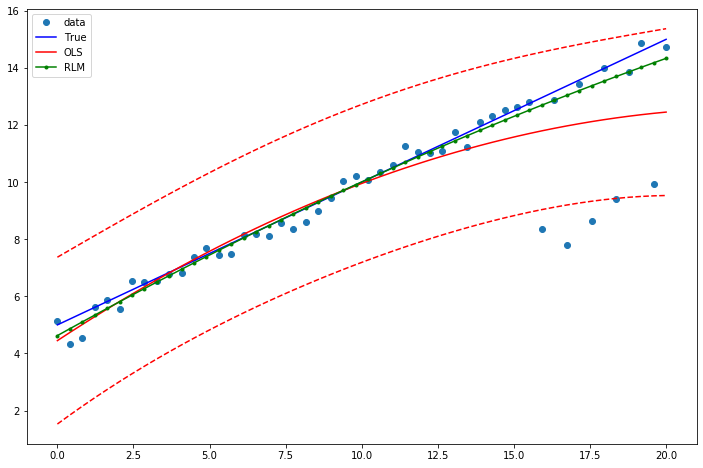

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:,[0,1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.43082312 0.40016454]
[0.39373415 0.03392573]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[4.96600288 0.4900169 ]
[0.10874737 0.00937011]


Draw a plot to compare OLS estimates to the robust estimates:

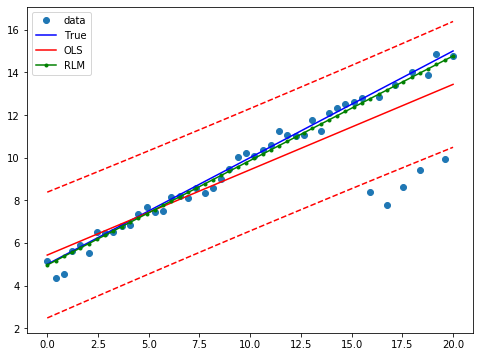

In [13]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x1, y2, 'o', label="data")
ax.plot(x1, y_true2, 'b-', label="True")
ax.plot(x1, res2.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm2.fittedvalues, 'g.-', label="RLM")
legend = ax.legend(loc="best")